In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
data1 = pd.read_csv("data/ice_options_2021.csv")
data2 = pd.read_csv("data/ice_options_2022.csv")
data3 = pd.read_csv("data/ice_options_2023.csv")
ice_options = pd.concat([data1, data2, data3], ignore_index=True)
ice_stock_df = pd.read_csv("data/ice_stock_2021_2023.csv",index_col="date", parse_dates=["date"])

In [3]:
ice_stock_df

,S
date,
2021-01-04,113.30000
2021-01-05,113.54000
2021-01-06,115.74000
2021-01-07,115.81000
2021-01-08,117.63000
...,...
2023-12-22,125.72000
2023-12-26,126.65000
2023-12-27,127.79000


In [4]:
import math

def bs_delta(S, K, T, sigma, r, cp_flag):
    """
    Black–Scholes delta for European calls/puts.

    S      : spot
    K      : strike
    T      : time to maturity in years
    sigma  : vol (annualized)
    r      : risk-free rate (annualized, cont. comp.)
    cp_flag: 'C' for call, 'P' for put
    """
    # handle expiry / degenerate cases
    if T <= 0 or sigma <= 0:
        if cp_flag.upper() == "C":
            return float(S > K)   # 1 if in-the-money, else 0
        else:
            return -float(S < K)  # -1 if in-the-money, else 0

    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    # standard normal CDF via erf
    Nd1 = 0.5 * (1.0 + math.erf(d1 / math.sqrt(2.0)))

    if cp_flag.upper() == "C":
        return Nd1
    else:  # put
        return Nd1 - 1.0


In [21]:
def compute_delta_row(row, r=0.01):
    """
    Compute BS delta using a dataframe row.

    Assumes:
      - row['S'] is spot
      - row['strike_price'] is encoded like 100000 -> 100.0
      - row['impl_volatility'] is annualized vol
      - row['date'], row['exdate'] are datetime64
      - row['cp_flag'] is 'C' or 'P'
    """
    S = float(row["S"])
    K = float(row["strike_price"]) / 1000.0   # adjust if your strikes are already in price units
    sigma = float(row["impl_volatility"])
    T = (row["exdate"] - row["date"]).days / 252

    return bs_delta(S, K, T, sigma, r, row["cp_flag"])


In [6]:
call230120C100000 = ice_options[ice_options["symbol"] == "ICE 230120C100000"].sort_values(by="date").reset_index(drop=True)
call230120C100000["date"] = pd.to_datetime(call230120C100000["date"])
call230120C100000["exdate"] = pd.to_datetime(call230120C100000["exdate"])
call230120C100000["impl_volatility"] = call230120C100000["impl_volatility"].ffill().bfill()

In [7]:
call230120C100000.loc[510:513]["delta"]

510    0.947938
511         NaN
512         NaN
513    0.966861
Name: delta, dtype: float64

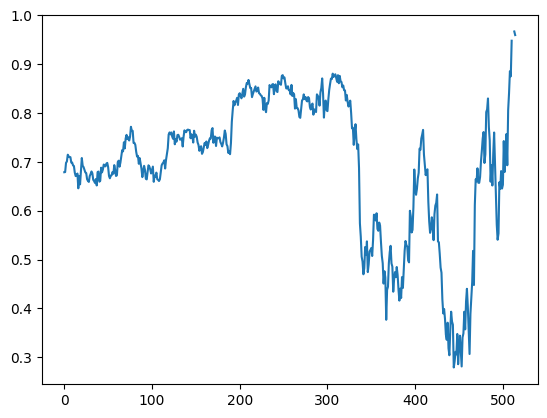

In [8]:
plt.plot(call230120C100000["delta"])

In [9]:


# merge on calendar dates where we have BOTH option and stock
df = call230120C100000.merge(
    ice_stock_df,
    left_on="date",
    right_on=ice_stock_df.index,
    how="inner"
)

# keep only what we need for now
cols_keep = [
    "date", "exdate", "cp_flag", "strike_price",
    "best_bid", "best_offer", "delta",
    "contract_size", "S","impl_volatility"
]
df = df[cols_keep].copy()

In [10]:
df.iloc[len(df)-5:len(df)]

,date,exdate,cp_flag,strike_price,best_bid,best_offer,delta,contract_size,S,impl_volatility
511,2023-01-13,2023-01-20,C,100000.0,7.5,7.9,NaN,100.0,107.63,0.392652
512,2023-01-17,2023-01-20,C,100000.0,7.0,7.4,NaN,100.0,107.41,0.392652
513,2023-01-18,2023-01-20,C,100000.0,7.5,8.0,0.966861,100.0,107.67,0.551438
514,2023-01-19,2023-01-20,C,100000.0,6.8,7.2,0.959488,100.0,106.92,0.742223
515,2023-01-20,2023-01-20,C,100000.0,8.2,8.6,NaN,100.0,108.48,0.742223


In [11]:
mask_nan = df["delta"].isna()
df.loc[mask_nan, "delta"] = df.loc[mask_nan].apply(compute_delta_row, axis=1)


In [12]:
df.loc[510:513]["delta"]

510    0.947938
511    0.916659
512    0.978730
513    0.966861
Name: delta, dtype: float64

In [13]:
df["mid"] = 0.5 * (df["best_bid"] + df["best_offer"])

# Num of contracts and multiplier
n_contracts = 1
contract_size = df["contract_size"].iloc[0]  # should be 100

df["V"] = df["mid"] * contract_size*n_contracts

In [14]:
df["V"]

0      2385.0
1      2390.0
2      2545.0
3      2490.0
4      2625.0
        ...  
511     770.0
512     720.0
513     775.0
514     700.0
515     840.0
Name: V, Length: 516, dtype: float64

In [15]:
df.isnull().sum()

date               0
exdate             0
cp_flag            0
strike_price       0
best_bid           0
best_offer         0
delta              0
contract_size      0
S                  0
impl_volatility    0
mid                0
V                  0
dtype: int64

In [16]:
df["V"]

0      2385.0
1      2390.0
2      2545.0
3      2490.0
4      2625.0
        ...  
511     770.0
512     720.0
513     775.0
514     700.0
515     840.0
Name: V, Length: 516, dtype: float64

In [17]:
df["H"] = - df["delta"] * contract_size * n_contracts

In [18]:
import numpy as np

def hedging_pnl_accounting(S, V, H, kappa):
    """
    Accounting P&L with proportional transaction costs.

    S, V, H : arrays of length n+1
        S_t : stock prices
        V_t : value of option position (here: long call)
        H_t : stock position held on [t_i, t_{i+1})
    kappa : float
        proportional trading cost (e.g. 0.001 = 10 bps)
    """
    S = np.asarray(S, float)
    V = np.asarray(V, float)
    H = np.asarray(H, float)

    assert len(S) == len(V) == len(H)
    n = len(S) - 1

    dV = V[1:] - V[:-1]        # option value changes
    dS = S[1:] - S[:-1]        # stock price changes
    dH = H[1:] - H[:-1]        # hedging rebalances

    trading_costs = kappa * np.abs(S[1:] * dH)   # κ | S_{i+1} (H_{i+1} - H_i) |

    # per-step reward (PnL increment)
    R = dV + H[:-1] * dS - trading_costs

    # initial + final liquidation trading costs
    init_cost = kappa * abs(S[0] * H[0])
    final_cost = kappa * abs(S[-1] * H[-1])

    pnl_steps = np.concatenate(([-init_cost], R, [-final_cost]))
    pnl_path = np.cumsum(pnl_steps)
    pnl_total = pnl_path[-1]

    return pnl_total, pnl_path


In [19]:

# recompute V with this last point
S = df["S"].values
V = df["V"].values
H = df["H"].values

for kappa in [0.0005, 0.001, 0.002]:  # 5, 10, 20 bps
    pnl_kappa, _ = hedging_pnl_accounting(S, V, H, kappa)
    print(f"kappa={kappa:.4f} → PnL={pnl_kappa:.2f}")

kappa=0.0005 → PnL=-367.46
kappa=0.0010 → PnL=-427.59
kappa=0.0020 → PnL=-547.83


In [20]:
import numpy as np
# compute payoff per option
S_T = df["S"].iloc[-1]
K   = df["strike_price"].iloc[0] / 1000.0   # adjust if needed
cp  = df["cp_flag"].iloc[0]

if cp == "C":
    payoff_per_option = max(S_T - K, 0.0)
else:
    payoff_per_option = max(K - S_T, 0.0)

contract_size = df["contract_size"].iloc[0]

S = df["S"].values
V = df["V"].values
H = df["H"].values

# 1) Option-only PnL (using payoff at expiry)
premium0 = V[0]                       # what you paid at t0
payoff_T = max(S[-1] - K, 0.0) * contract_size
option_pnl = payoff_T - premium0

print("Premium paid at t0       :", premium0)
print("Payoff at expiry         :", payoff_T)
print("Option-only PnL          :", option_pnl)

# 2) Hedge-only PnL on stock (no trading costs)
dS = np.diff(S)
hedge_pnl = np.sum(H[:-1] * dS)       # H_i held over [t_i, t_{i+1})

print("Hedge-only stock PnL     :", hedge_pnl)

# 3) Combined PnL
combined = option_pnl + hedge_pnl
print("Option + hedge PnL       :", combined)

# 4) Compare with hedging_pnl_accounting
kappa = 0.0
pnl_total, pnl_path = hedging_pnl_accounting(S, V, H, kappa)
print("PnL from accounting func :", pnl_total)


Premium paid at t0       : 2385.0
Payoff at expiry         : 848.0000000000005
Option-only PnL          : -1536.9999999999995
Hedge-only stock PnL     : 1237.6611112257744
Option + hedge PnL       : -299.3388887742251
PnL from accounting func : -307.3388887742259
